In [1]:
from math import log, sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import sklearn.metrics as metrics

from sklearn import preprocessing
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
colors = np.array(['#0101DF','#DF0101','#01DF01'])


rs = 42
def compute_metrics (y_test2,y_pred):
    accuracy = metrics.accuracy_score(y_test2,y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    precision = metrics.precision_score(y_test2,y_pred)
    print("Precision: %.2f%%" % (precision * 100.0))
    
    recall = metrics.recall_score(y_test2,y_pred)
    print("Recall: %.2f%%" % (recall * 100.0))
    
    F1Score = metrics.f1_score(y_test2,y_pred)
    print("F1 Score: %.2f%%" % (F1Score * 100.0))
    
    print('CONFUSION MATRIX:')
    conf_m = metrics.confusion_matrix(y_test2,y_pred)
    print(conf_m)
    print()

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=100,random_state=rs)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred

def RandomForest (X_train,y_train,X_test,y_test):
    for i in range(1,3):
        print('dep: '+str(i))
        rfc = RandomForestClassifier(max_depth=i, random_state=rs,verbose=True)
        rfc.fit(X_train,y_train)
        y_pred = rfc.predict(X_test)
        compute_metrics(y_test,y_pred)

def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()

Using TensorFlow backend.


Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426905, 1: 113031})
0: 92.66%
1: 7.34%


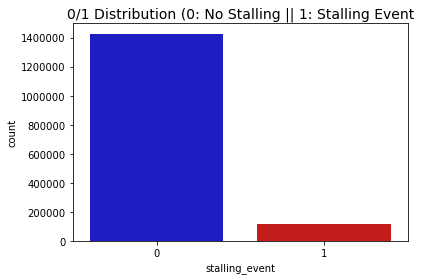

In [2]:
dataset = pd.read_csv('../output/df_general.csv', sep=',')
split = 0.8
del dataset['No.']
del dataset['Protocol']
del dataset['tcp_flag_cwr']
del dataset['tcp_flag_ecn']
del dataset['tcp_flag_urg']
del dataset['ip_len']
del dataset['tcp_flag_psh']
del dataset['tcp_flag_fin']
del dataset['prebuffering']
del dataset['Time']

dataset = dataset.fillna(dataset.mean())

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

(1539936, 10)
(1538832, 10)
0.4992

dataset[stalling_event]
Counter({0: 1425825, 1: 113007})
0: 92.66%
1: 7.34%


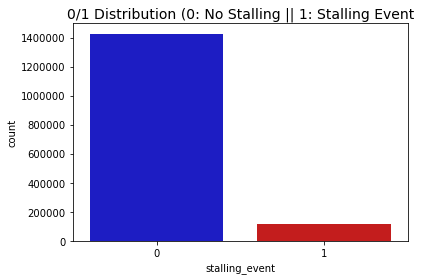

(0.0, 65335.0)

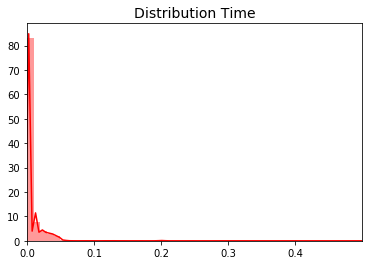

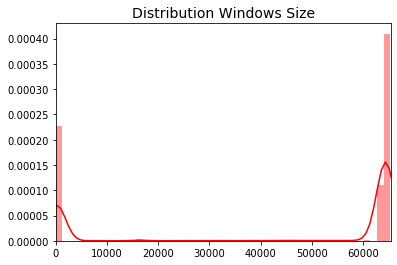

In [3]:
id = list(dataset[dataset['∆t']>0.5].index)
print(dataset.shape)
dataset = dataset.drop(id)
print(dataset.shape)
print(max(dataset['∆t']))
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

time_val = dataset['∆t'].values
win_val = dataset['tcp_win_si2'].values

fig = plt.figure()
sns.distplot(time_val,color='r')
plt.title('Distribution Time',fontsize=14)
plt.xlim([min(time_val),max(time_val)])

fig = plt.figure()
sns.distplot(win_val,color='r')
plt.title('Distribution Windows Size',fontsize=14)
plt.xlim([min(win_val),max(win_val)])

In [4]:
robSca = preprocessing.RobustScaler()
dataset['scaled_time'] = robSca.fit_transform(dataset['∆t'].values.reshape(-1,1))
dataset['scaled_pktlen'] = robSca.fit_transform(dataset['pkt_len'].values.reshape(-1,1))
dataset['scaled_tcphea'] = robSca.fit_transform(dataset['tcp_hea_len'].values.reshape(-1,1))
dataset['scaled_tcpwin'] = robSca.fit_transform(dataset['tcp_win_si2'].values.reshape(-1,1))
dataset.drop(['∆t','pkt_len','tcp_hea_len','tcp_win_si2'], axis=1, inplace=True)
dataset = dataset[['scaled_time','scaled_pktlen','scaled_tcphea','scaled_tcpwin','tcp_flag_ack', 'tcp_flag_rst', 'tcp_flag_syn','delay','capture','stalling_event']]
print(dataset.columns)

Index(['scaled_time', 'scaled_pktlen', 'scaled_tcphea', 'scaled_tcpwin',
       'tcp_flag_ack', 'tcp_flag_rst', 'tcp_flag_syn', 'delay', 'capture',
       'stalling_event'],
      dtype='object')


In [5]:
from random import randint
'''X_train = [None] * (len(dataset.columns)-1)
X_test = [None] * (len(dataset.columns)-1)'''

X_train = np.array([None]*7)
X_test = np.array([None]*7)
y_train = list()
y_test = list()

grouped = dataset.groupby(['delay','capture']) 
#print(grouped.mean())

for id, data in grouped:
    spl = int(data.shape[0] * split);
    restspl = int(data.shape[0] * (1-split))
    randnum = randint(0,restspl)
    '''print('data.shape: '+str(data.shape)+' | spl: '+str(spl)+
          ' | restspl: '+str(restspl)+' | randnum: '+str(randnum)+
          ' | 0:randnum='+str(range(0,randnum)) +' | randnum:randnum+spl= '+str(range(randnum,randnum+spl))+
          ' | randnum+spl: = '+str(range(randnum+spl,data.shape[0])))'''
    X_train = np.vstack((X_train,data.values[randnum:randnum+spl,:-3]))
    X_test = np.vstack((X_test,data.values[0:randnum-1,:-3]))
    X_test = np.vstack((X_test,data.values[randnum+spl:,:-3]))
    
    y_train.extend(data.values[randnum:randnum+spl,-1])
    y_test.extend(data.values[0:randnum-1,-1])
    y_test.extend(data.values[randnum+spl:,-1])
    '''X_train.extend(data.loc[randnum:randnum+spl][data.columns[:-3]].values.tolist())
    X_test.extend(data.loc[0:randnum][data.columns[:-3]].values.tolist())
    X_test.extend(data.loc[randnum+spl:][data.columns[:-3]].values.tolist())
    y_train.extend(data.loc[randnum:randnum+spl,data.columns=='stalling_event'].values.tolist())
    y_test.extend(data.loc[0:randnum,data.columns=='stalling_event'].values.tolist())
    y_test.extend(data.loc[randnum+spl:,data.columns=='stalling_event'].values.tolist())'''
X_train = X_train[1:]
X_test = X_test[1:]


In [6]:
y_test = list(map(int,y_test))
y_train = list(map(int,y_train))
Ratio10(y_test,'y_test')
Ratio10(y_train,'y_train')


y_test
Counter({0: 303436, 1: 4299})
0: 98.60%
1: 1.40%

y_train
Counter({0: 1122330, 1: 108707})
0: 91.17%
1: 8.83%


In [7]:
X_train = pd.DataFrame(data=X_train,columns=dataset.columns[:-3])
X_test= pd.DataFrame(data=X_test,columns=dataset.columns[:-3])

y_train = pd.DataFrame(data=y_train,columns=['y_train'])
y_test= pd.DataFrame(data=y_test,columns=['y_test'])

   df_y_rus
0         0
1         0
2         0
3         0
4         0
  scaled_time scaled_pktlen scaled_tcphea scaled_tcpwin tcp_flag_ack  \
0    0.806452             0             0    -0.0055027            1   
1  -0.0322581             0             0    0.00645091            1   
2     13.5161             0             0   -0.00548716            1   
3    0.516129             0             0   0.000886029            1   
4  -0.0645161             0             0             0            1   

  tcp_flag_rst tcp_flag_syn  
0            0            0  
1            0            0  
2            0            0  
3            0            0  
4            0            0  

df_y_rus
Counter({0: 108707, 1: 108707})
0: 50.00%
1: 50.00%


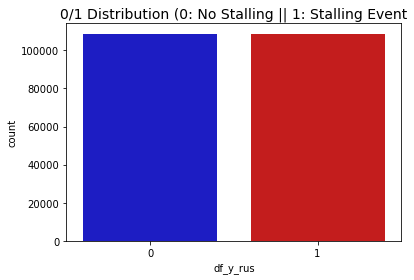

In [8]:
rus = RandomUnderSampler(random_state=rs)
X_rus,y_rus = rus.fit_resample(X_train.values,y_train.values)
df_y_rus = pd.DataFrame({'df_y_rus':y_rus.T.ravel()})
df_X_rus = pd.DataFrame(data=X_rus,columns=dataset.columns[:-3])
print(df_y_rus.head())
print(df_X_rus.head())
Ratio10(df_y_rus['df_y_rus'],'df_y_rus')
histo(df_y_rus,'df_y_rus')

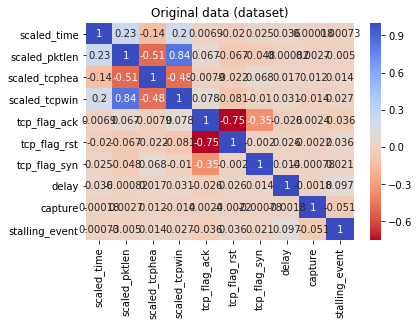

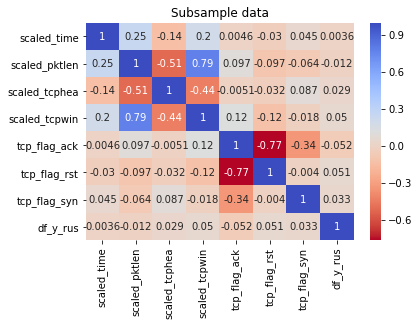

In [9]:
#df = pd.concat([df_X_rus,df_y_rus],axis=1)
#print(df.head())
#corr = df.corr(method='pearson')
corr = dataset.corr()
fig = plt.figure()
sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':10},annot=True)
plt.title('Original data (dataset)')
fig.savefig('figures/correlation_matrix.png',dpi=100)
plt.show()

df = pd.concat([df_X_rus.astype(float),df_y_rus],axis=1)
corr = df.corr()
#df = pd.concat([X_train,y_train],axis=1)
fig = plt.figure()
sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':10},annot=True)
plt.title('Subsample data')
fig.savefig('figures/correlation_matrix.png',dpi=100)
plt.show()

157.09677419354838


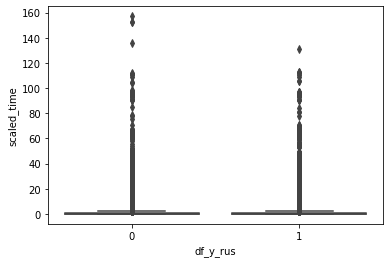

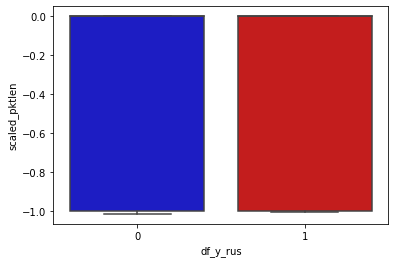

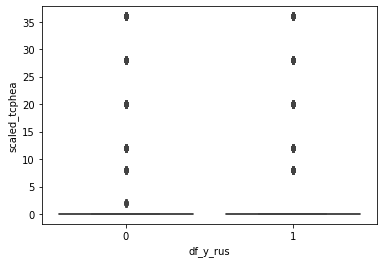

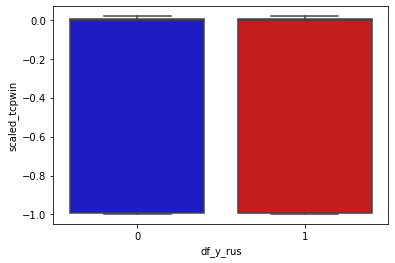

In [10]:
print(max(df['scaled_time']))
fig = plt.figure()
sns.boxplot(x='df_y_rus',y='scaled_time',data=df,palette=colors)
plt.show()
fig = plt.figure()
sns.boxplot(x='df_y_rus',y='scaled_pktlen',data=df,palette=colors)
plt.show()
fig = plt.figure()
sns.boxplot(x='df_y_rus',y='scaled_tcphea',data=df,palette=colors)
plt.show()
fig = plt.figure()
sns.boxplot(x='df_y_rus',y='scaled_tcpwin',data=df,palette=colors)
plt.show()

[0 0 0 ... 1 1 1]
['#0101DF' '#0101DF' '#0101DF' ... '#DF0101' '#DF0101' '#DF0101']


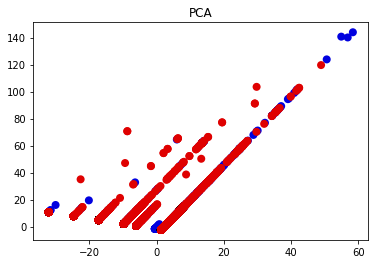

In [11]:
#X_train_tsne = TSNE(n_components=2,random_state=rs).fit_transform(X_rus.values)
X_train_pca = PCA(n_components=2,random_state=rs).fit_transform(df_X_rus.values)
#X_train_svd = TruncatedSVD(n_components=2,algorithm='randomized',random_state=rs).fit_transform(X_rus.values)

y_arr = (df_y_rus['df_y_rus'].values)
print(y_arr)
fig = plt.figure()
ycolors = colors[y_arr]
print(ycolors)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=ycolors,cmap='coolwarm',linewidths=2)
plt.title('PCA')
plt.show()

[0 0 0 ... 1 1 1]
['#0101DF' '#0101DF' '#0101DF' ... '#DF0101' '#DF0101' '#DF0101']


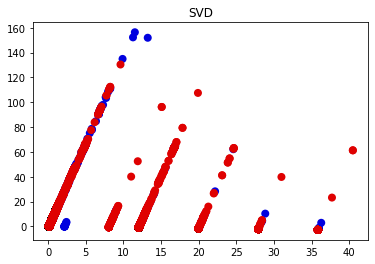

In [12]:
#X_train_tsne = TSNE(n_components=2,random_state=rs).fit_transform(X_rus.values)
#X_train_pca = PCA(n_components=2,random_state=rs).fit_transform(df_X_rus.values)
X_train_svd = TruncatedSVD(n_components=2,algorithm='randomized',random_state=rs).fit_transform(df_X_rus.values)

y_arr = (df_y_rus['df_y_rus'].values)
print(y_arr)
fig = plt.figure()
ycolors = colors[y_arr]
print(ycolors)
plt.scatter(X_train_svd[:,0],X_train_svd[:,1],c=ycolors,cmap='coolwarm',linewidths=2)
plt.title('SVD')
plt.show()

In [13]:
'''from sklearn.model_selection import cross_val_score

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}
for key, classifier in classifiers.items():
    classifier.fit(df_X_rus.values, df_y_rus.values)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")'''

'from sklearn.model_selection import cross_val_score\n\nclassifiers = {\n    "LogisiticRegression": LogisticRegression(),\n    "KNearest": KNeighborsClassifier(),\n    "Support Vector Classifier": SVC(),\n    "DecisionTreeClassifier": DecisionTreeClassifier()\n}\nfor key, classifier in classifiers.items():\n    classifier.fit(df_X_rus.values, df_y_rus.values)\n    training_score = cross_val_score(classifier, X_train, y_train, cv=5)\n    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")'

In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import psutil
from multiprocessing import Pool
from random import random

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


def log_reg(X,y):
    # Logistic Regression 
    print('Log_reg')
    grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
    grid_log_reg.fit(X,y)
    # We automatically get the logistic regression with the best parameters.
    log_reg = grid_log_reg.best_estimator_
    log_reg_score = cross_val_score(log_reg, X,y, cv=5)
    print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')
    
def knears(X,y):
    print('Knears')
    knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

    grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
    grid_knears.fit(X,y)
    # KNears best estimator
    knears_neighbors = grid_knears.best_estimator_
    knears_score = cross_val_score(knears_neighbors, X, y, cv=5)
    print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')
    
def svc(X,y):
    print('SVC')
    # Support Vector Classifier
    svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
    grid_svc = GridSearchCV(SVC(), svc_params)
    grid_svc.fit(X,y)
    
    # SVC best estimator
    svc = grid_svc.best_estimator_
    svc_score = cross_val_score(svc, X, y, cv=5)
    print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

def DTC(X,y):
    print('DTC')
    # DecisionTree Classifier
    tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
                  "min_samples_leaf": list(range(5,7,1))}
    grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
    grid_tree.fit(X,y)
    
    # tree best estimator
    tree_clf = grid_tree.best_estimator_
    tree_score = cross_val_score(tree_clf, X, y, cv=5)
    print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

def general(var):
    if var == 0:
        log_reg(df_X_rus.values,df_y_rus.values)
    elif var == 1:
        knears(df_X_rus.values,df_y_rus.values)
    elif var == 2:
        svc(df_X_rus.values,df_y_rus.values)
    elif var == 3:
        DTC(df_X_rus.values,df_y_rus.values)
if __name__ == '__main__':
    time0 = time.time()
    cpu = psutil.cpu_count()
    print('cpu %i'%cpu)
    pool = Pool(cpu)
    print('estoy aquí')
    pool.map(general,[0,1,2,3])
    time1 = time.time()
    print('time ASYNC PARALLEL: %2.10f' %(time1-time0))

cpu 4
estoy aquí


In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, df_X_rus.values, df_y_rus.values, (0.87, 1.01), cv=cv, n_jobs=4)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()